In [169]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from feature_extraction_funcs import *
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
import spacy
import enchant
plt.figure(figsize=(20,10))
nlp = spacy.load("en_core_web_lg")

<Figure size 1440x720 with 0 Axes>

In [2]:
# Importing cleaned dataset
wikihow = pd.read_csv('./datasets/clean_wikihow_sep.csv')

## Surface Features

Surface features are usually features based on structure of documents or sentences like position in document or paragraph, length (number of words in the sentence) or number of quoted words in a sentence. This comes with the intuition that sentences are more important is the number of words with the exception of stopwords is within a certain range x or the sentences containing too many quoted words are less important. 

In [3]:
wikihow = wikihow[['text_id', 'sentence', 'is_summary', 'words', 'title', 'sentence_len']]

In [4]:
wikihow.head()

,text_id,sentence,is_summary,words,title,sentence_len
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11
3,0,"Be it the few words, Twitter allows you or an ...",no,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21
4,0,Bring out the most salient features of your cr...,no,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18


In [5]:
only_summaries = wikihow[wikihow['is_summary'] == 'yes']['sentence_len']

Text(0.5, 1.0, 'Distribution of sentence lengths')

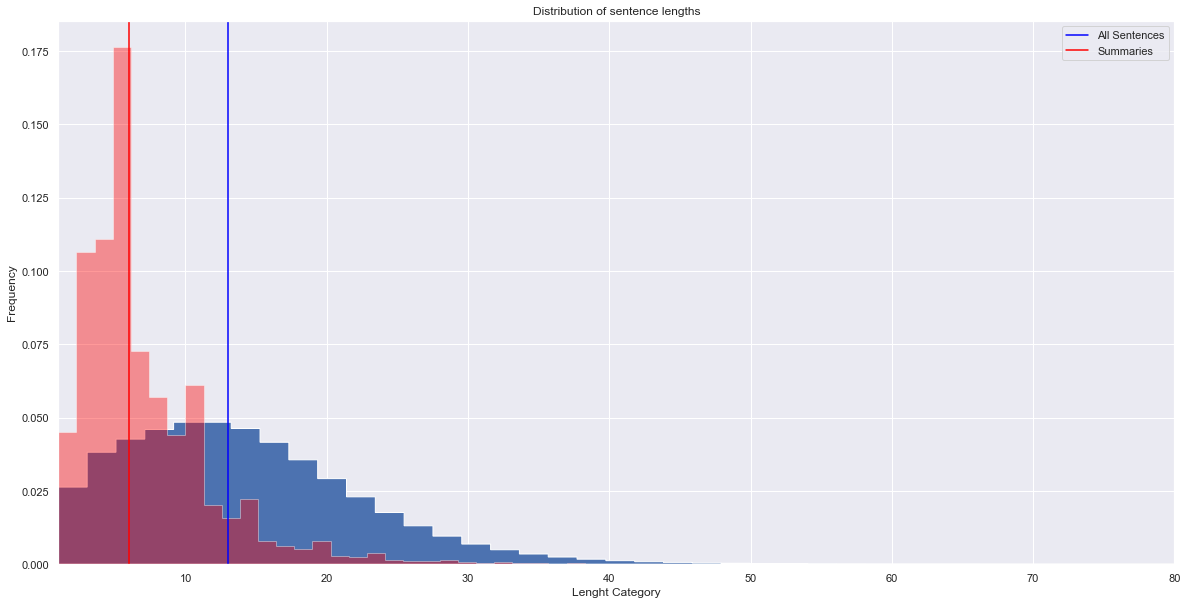

In [6]:
plt.figure(figsize=(20,10))
plt.hist(wikihow['sentence_len'],bins = 500, normed=True,histtype="stepfilled")
plt.hist(only_summaries,bins = 200, normed=True,histtype="stepfilled", color = 'red', alpha = 0.4)
plt.axvline(wikihow['sentence_len'].median(), color = 'blue')
plt.axvline(only_summaries.median(), color = 'red')
plt.xlim((1, 80)) 
plt.xlabel('Lenght Category')
plt.ylabel('Frequency')
plt.legend(['All Sentences','Summaries'],loc = 'upper right')
plt.title('Distribution of sentence lengths')

When comparing the distributions of `sentence_len` for summary sentences and non summary sentences, we can clearly see the summary sentences are overall shorter than the rest of sentences.

## Content Features
### Computing TF-IDF sentence scores
We will use tf-idf is used here to evaluate how important a sentence is in a document as well as compute the median tf-idf scores for summary sentences vs non-summary sentences. 

In [7]:
#extracting paragraphs
docs = wikihow.groupby('text_id')['sentence'].apply(list)

In [8]:
docs.head()

text_id
0    [Sell yourself first, Before doing anything el...
1    [Read the classics before 1600, Reading the cl...
2    [Join online artist communities, Depending on ...
3    [Make yourself public, Get yourself out there ...
4    [Blog about your artwork, Given the hundreds o...
Name: sentence, dtype: object

In [9]:
tf_idf_list = []
vectorizer = TfidfVectorizer()
for doc in docs:
    vectors = vectorizer.fit_transform(doc).toarray()
    for vector in vectors:
        tfidf_sent = np.sum(vector)
        tf_idf_list.append(tfidf_sent)
len(tf_idf_list)

7284000

In [10]:
wikihow['tfidf_score'] = tf_idf_list

In [11]:
wikihow.head()

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425
3,0,"Be it the few words, Twitter allows you or an ...",no,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21,4.393483
4,0,Bring out the most salient features of your cr...,no,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18,3.500784


In [12]:
wikihow_subset = wikihow[:10000]
med_summary = wikihow_subset[wikihow_subset['is_summary'] == 'yes']['tfidf_score'].median()
med_no_summary = wikihow_subset[wikihow_subset['is_summary'] == 'no']['tfidf_score'].median()
med_summary, med_no_summary

(2.205039956914569, 3.6839863235570576)

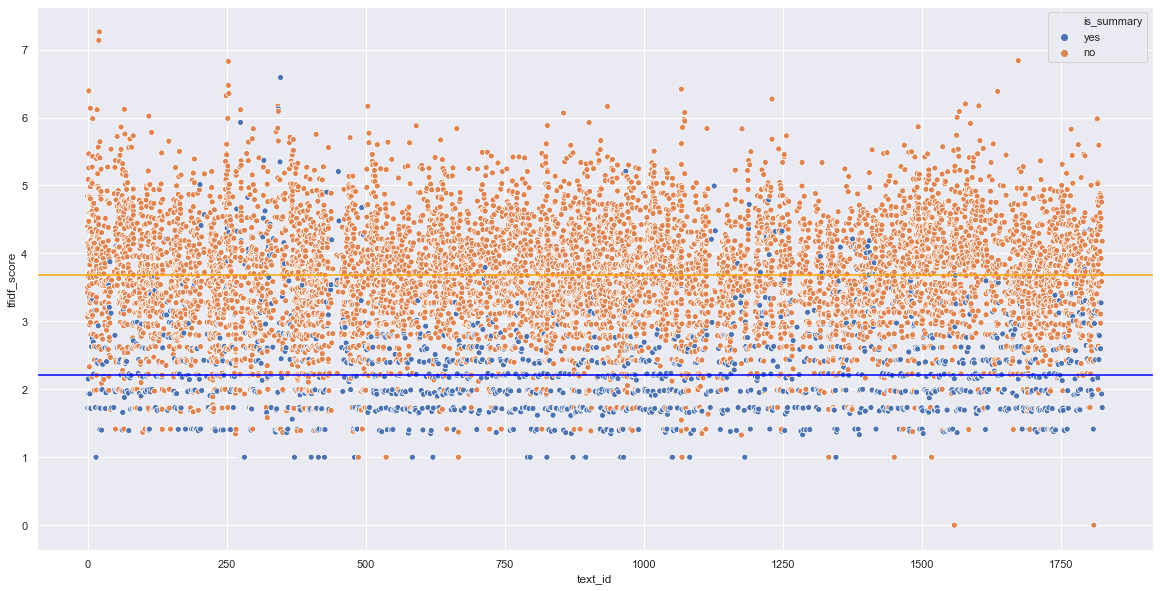

In [13]:
plt.figure(figsize=(20,10))
sns.scatterplot(y = 'tfidf_score', x = 'text_id', data = wikihow_subset, hue = 'is_summary')
plt.axhline(med_summary, color = 'blue')
plt.axhline(med_no_summary, color = 'orange')

Here it looks like sentences with the lowest tf-idf score are the ones that got picked as summary sentences. This can be due to the structure of the wikihow articles where the headline sometimes consists very little words. We will keep in mind that a wikihow article struucture is not representative of what a common text might be.

In [14]:
wikihow.to_csv('./datasets/wikihow_features_v1.csv', index = False)

## Relevance Features 

Another useful feature would be to use similarity to exploit intersentence relationship,for example the degree of similarity between a sentence and a title. The idea here is that sentences related to many other sentences are more relevant.

In [15]:
def get_similarity(term1, term2):
    sent1 = nlp(term1)
    sent2 = nlp(term2)
    return sent1.similarity(sent2)

In [16]:
wikihow_subset = wikihow.iloc[:100000]

In [17]:
wikihow_subset['title_similarity'] = wikihow_subset.apply(lambda x: get_similarity(x['sentence'], x['title']), axis = 1)

In [18]:
wikihow_subset

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score,title_similarity
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841,0.828910
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057,0.806864
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425,0.857768
3,0,"Be it the few words, Twitter allows you or an ...",no,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21,4.393483,0.815038
4,0,Bring out the most salient features of your cr...,no,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18,3.500784,0.789926
5,0,Make it clear to readers why you are an artist...,no,"['Make', 'it', 'clear', 'to', 'readers', 'why'...",How to Sell Fine Art Online,24,4.142737,0.867380
6,0,"If you re not great with words, find a friend ...",no,"['If', 'you', 're', 'not', 'great', 'with', 'w...",How to Sell Fine Art Online,29,4.846543,0.840578
7,1,Read the classics before 1600,yes,"['Read', 'the', 'classics', 'before', '1600']",How to Be Well Read,5,2.151917,0.741598
8,1,Reading the classics is the very first thing y...,no,"['Reading', 'the', 'classics', 'is', 'the', 'v...",How to Be Well Read,16,3.659740,0.958614
9,1,If you want to build a solid foundation for yo...,no,"['If', 'you', 'want', 'to', 'build', 'a', 'sol...",How to Be Well Read,33,5.087724,0.919967


In [19]:
wikihow_subset['title_similarity'].max()

0.985295263152068

In [20]:
wikihow_subset['title_similarity'].min()

-0.09509933094643085

In [21]:
def create_buckets(sim):
    if 0 <= sim < 0.25:
        return 'None'
    elif 0.25 <= sim < 0.5:
        return 'Weak'
    elif 0.5 <= sim < 0.70:
        return 'Medium'
    elif 0.70 <= sim < 0.90:
        return 'Strong'
    else:
        return 'Very Strong'
    

In [22]:
wikihow_subset['title_sim_categories'] = wikihow_subset['title_similarity'].apply(create_buckets)

In [23]:
wikihow_subset.head(3)

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score,title_similarity,title_sim_categories
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841,0.828910,Strong
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057,0.806864,Strong
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425,0.857768,Strong


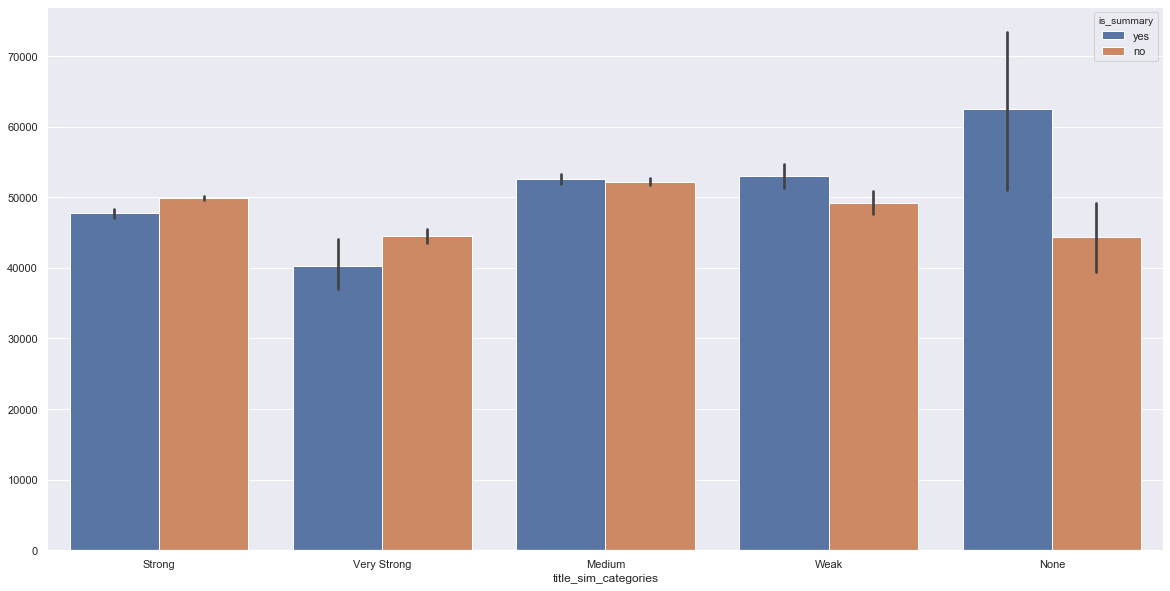

In [24]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=wikihow_subset.index, x="title_sim_categories", data=wikihow_subset, hue= 'is_summary')

This bar plot shows us that the similarity to title feature has roughly the same proportion for summary sentences and non summary sentences when falling into the `strong` and `very strong` buckets but again that can be due to the structure of the wikihow dataset and the way paragraph summaries are written.

## Most frequent words in a summary
From sentences with highest tf-idf score, we will pick the top most important words

In [40]:
#Create stop_word list
stop_words = set(stopwords.words('english'))

In [64]:
word_list = []
for sentence in wikihow_subset['sentence']:
    words = sentence.split(' ')
    for word in words:
        if word.lower() not in stop_words:
            word_list.append(word.lower())

In [65]:
counts = Counter(word_list)

In [66]:
#Let's pick the 20 most common words (stop words excluded)
most_common = counts.most_common()

In [69]:
top_occurences = ['help','use','get', 'make','like','need', 'take', 'try', 
                  'avoid','keep', 'want', 'many', 'ask', 'good', 'find', 'work', 
                  'go', 'include', 'important', 'know']
len(top_occurences)

20

In [76]:
def check_word(sentence, occurence):
    words = sentence.split(' ')
    for word in words:
        if word.lower() == occurence:
            return 1
        else:
            return 0


In [80]:
for occurence in top_occurences:
    wikihow_subset[occurence] = wikihow_subset['sentence'].apply(lambda x: check_word(x, occurence))

In [184]:
wikihow_subset.head(3)

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score,title_similarity,title_sim_categories,help,...,want,many,ask,good,find,work,go,include,important,know
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841,0.828910,Strong,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057,0.806864,Strong,0,...,0,0,0,0,0,0,0,0,0,0
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425,0.857768,Strong,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
wikihow_subset['help'].mean()

0.00058

In [87]:
#Calculating means of 0-1 for summary category and non summary category
occurence_means_summary = dict()
occurence_means_no_summary = dict()
for occurence in top_occurences:
    mean_summary = wikihow_subset[wikihow_subset['is_summary']=='yes'][occurence].mean()
    occurence_means_summary[occurence] = mean_summary
    
    mean_no_summary = wikihow_subset[wikihow_subset['is_summary']=='no'][occurence].mean()
    occurence_means_no_summary[occurence] = mean_no_summary

In [148]:
summary_mean = pd.DataFrame(occurence_means_summary.items(), columns = ['word','mean'])

In [152]:
no_summary_mean = pd.DataFrame(occurence_means_no_summary.items(), columns = ['word','mean'])

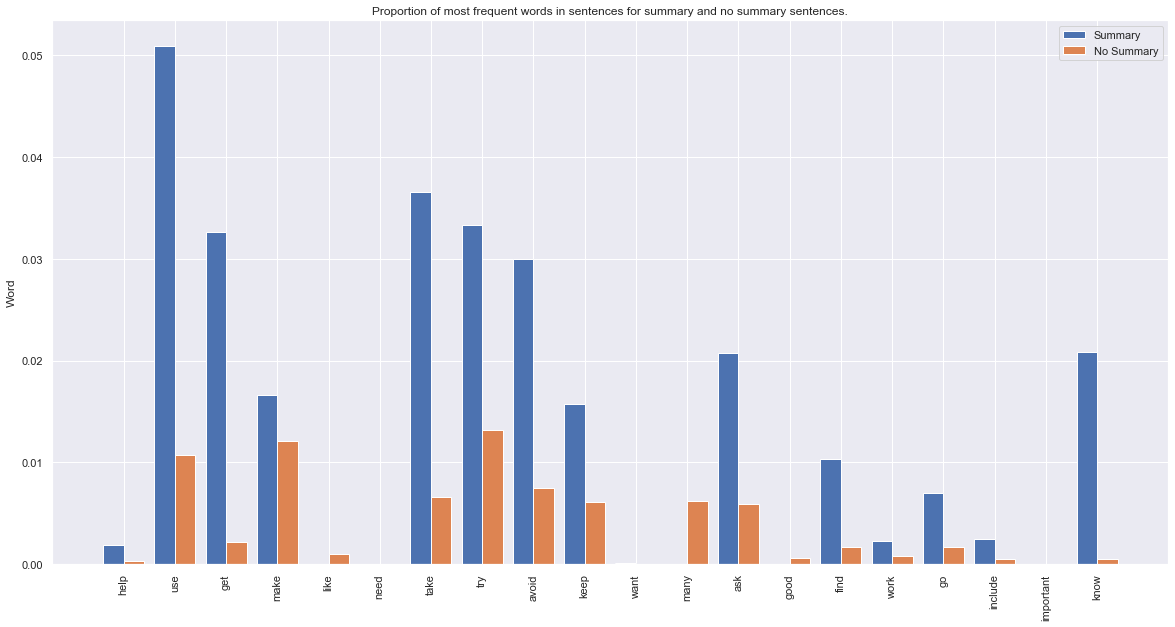

<Figure size 1440x2880 with 0 Axes>

In [183]:
labels = top_occurences
summary_means = summary_mean['mean']
non_summary_means = no_summary_mean['mean']

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
plt.figure(figsize=(20,40))
rects1 = ax.bar(x - width/2, summary_means, width, label='Summary')
rects2 = ax.bar(x + width/2, non_summary_means, width, label='No Summary')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Word')
ax.set_title('Proportion of most frequent words in sentences for summary and no summary sentences.')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()


It looks like some of the most frequent words are more present in summary sentences than others.

In [186]:
#wikihow.to_csv('./datasets/wikihow_sep_features.csv')
#wikihow_subset.to_csv('./datasets/wikihow_sep_subset.csv')